1. Change our model to use a 5 × 5 kernel with `kernel_size=5` passed to the `nn.Conv2d` constructor.

    1. What impact does this change have on the number of parameters in the model? <br>
          ~10K more parameters <br>
          kernel size 3: `(136978, [864, 32, 4608, 16, 131072, 128, 256, 2])` <br>
          kernel size 4: `(146706, [2400, 32, 12800, 16, 131072, 128, 256, 2])` <br><br>
    2. Does the change improve or degrade overfitting? <br>
        Model grossly overfits <br><br>
    3. Read https://pytorch.org/docs/stable/nn.html#conv2d. <br><br>
    4. Can you describe what `kernel_size=(1,3)` will do?
        A kernel with height of 1 and width 3. <br>
        Depending on the padding the shape of the image will change <br><br>
    5. How does the model behave with such a kernel?<br>
        Model overfits but not grossly. It's also important to adjust the padding <br>
        so that we don't lose any pixel/information.<br><br>

2. Can you find an image that contains neither a bird nor an airplane, but that the model claims has one or the other with more than 95% confidence? <br>
    Found a wagon that is predicted as plane and a horse as bird
    1. Can you manually edit a neutral image to make it more airplane-like?<br>
    <br><br>
    2. Can you manually edit an airplane image to trick the model into reporting a bird?<br>
    <br><br>
    3. Do these tasks get easier with a network with less capacity? More capacity?<br>
        From all the models trained in chapter 8 and this exercise, it seems more capacity only leads to overfitting.<br>
        Perhaps we could get more training data to improve accuracy <br>

In [102]:
import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms


In [166]:
data_path = '../data/p1ch7/'

cifar = datasets.CIFAR10(
        data_path, train=True, download=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
                             ])
)

cifar_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
)

len(cifar), len(cifar_val)

(50000, 10000)

In [167]:
label_map = {0:0, 2:1}
class_name = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar_val if label in [0, 2]]

len(train), len(val)

(10000, 2000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


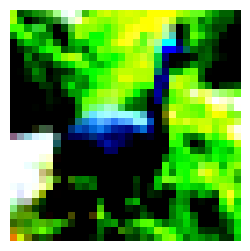

In [169]:
img, _ = cifar2[0]

plt.figure(figsize=(3, 3))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off');

In [170]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [171]:
device = (torch.device('mps') if torch.backends.mps.is_available()
else torch.device('cpu'))

device

device(type='mps')

In [172]:
class ConvKer5(nn.Module):
    def __init__(self, n_chl=32):
        super().__init__()
        self.n_chl = n_chl
        self.conv1 = nn.Conv2d(3, n_chl, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(n_chl, n_chl//2, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(n_chl//2*8*8, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)

        x = x.view(-1, self.n_chl//2*8*8)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)

        return x

In [173]:
model = ConvKer5().to(device=device)

p_numel = [p.numel() for p in model.parameters()]
sum(p_numel), p_numel

(146706, [2400, 32, 12800, 16, 131072, 128, 256, 2])

In [174]:
def training_loop(n_epochs, optimizer, model, loss_fn, trian_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outs = model(imgs)
            loss = loss_fn(outs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch:{epoch} Train Loss:{loss_train/len(train_loader):.5f}')
        

In [175]:
def validate(model, train_loader, val_loader):
    acc_dict = {}
    for (name, loader) in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                outs = model(imgs)
                _, predicted = torch.max(outs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        acc_dict[name] = correct/total
        print(f'{name} accuracy: {acc_dict[name]:.2f}')
    
    return acc_dict

In [176]:
model = ConvKer5().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    100,
    optimizer,
    model,
    loss_fn,
    train_loader
)

model.eval()
validate(model, train_loader, val_loader)

2024-02-24 18:01:31.884407 Epoch:1 Train Loss:0.53040
2024-02-24 18:01:42.147247 Epoch:10 Train Loss:0.30696
2024-02-24 18:01:53.354876 Epoch:20 Train Loss:0.25391
2024-02-24 18:02:04.398362 Epoch:30 Train Loss:0.21202
2024-02-24 18:02:15.369766 Epoch:40 Train Loss:0.17946
2024-02-24 18:02:26.498690 Epoch:50 Train Loss:0.14561
2024-02-24 18:02:37.400117 Epoch:60 Train Loss:0.11644
2024-02-24 18:02:48.326308 Epoch:70 Train Loss:0.08728
2024-02-24 18:02:59.226427 Epoch:80 Train Loss:0.06169
2024-02-24 18:03:10.228626 Epoch:90 Train Loss:0.04045
2024-02-24 18:03:21.484127 Epoch:100 Train Loss:0.02708
train accuracy: 1.00
val accuracy: 0.89


{'train': 0.9971, 'val': 0.8855}

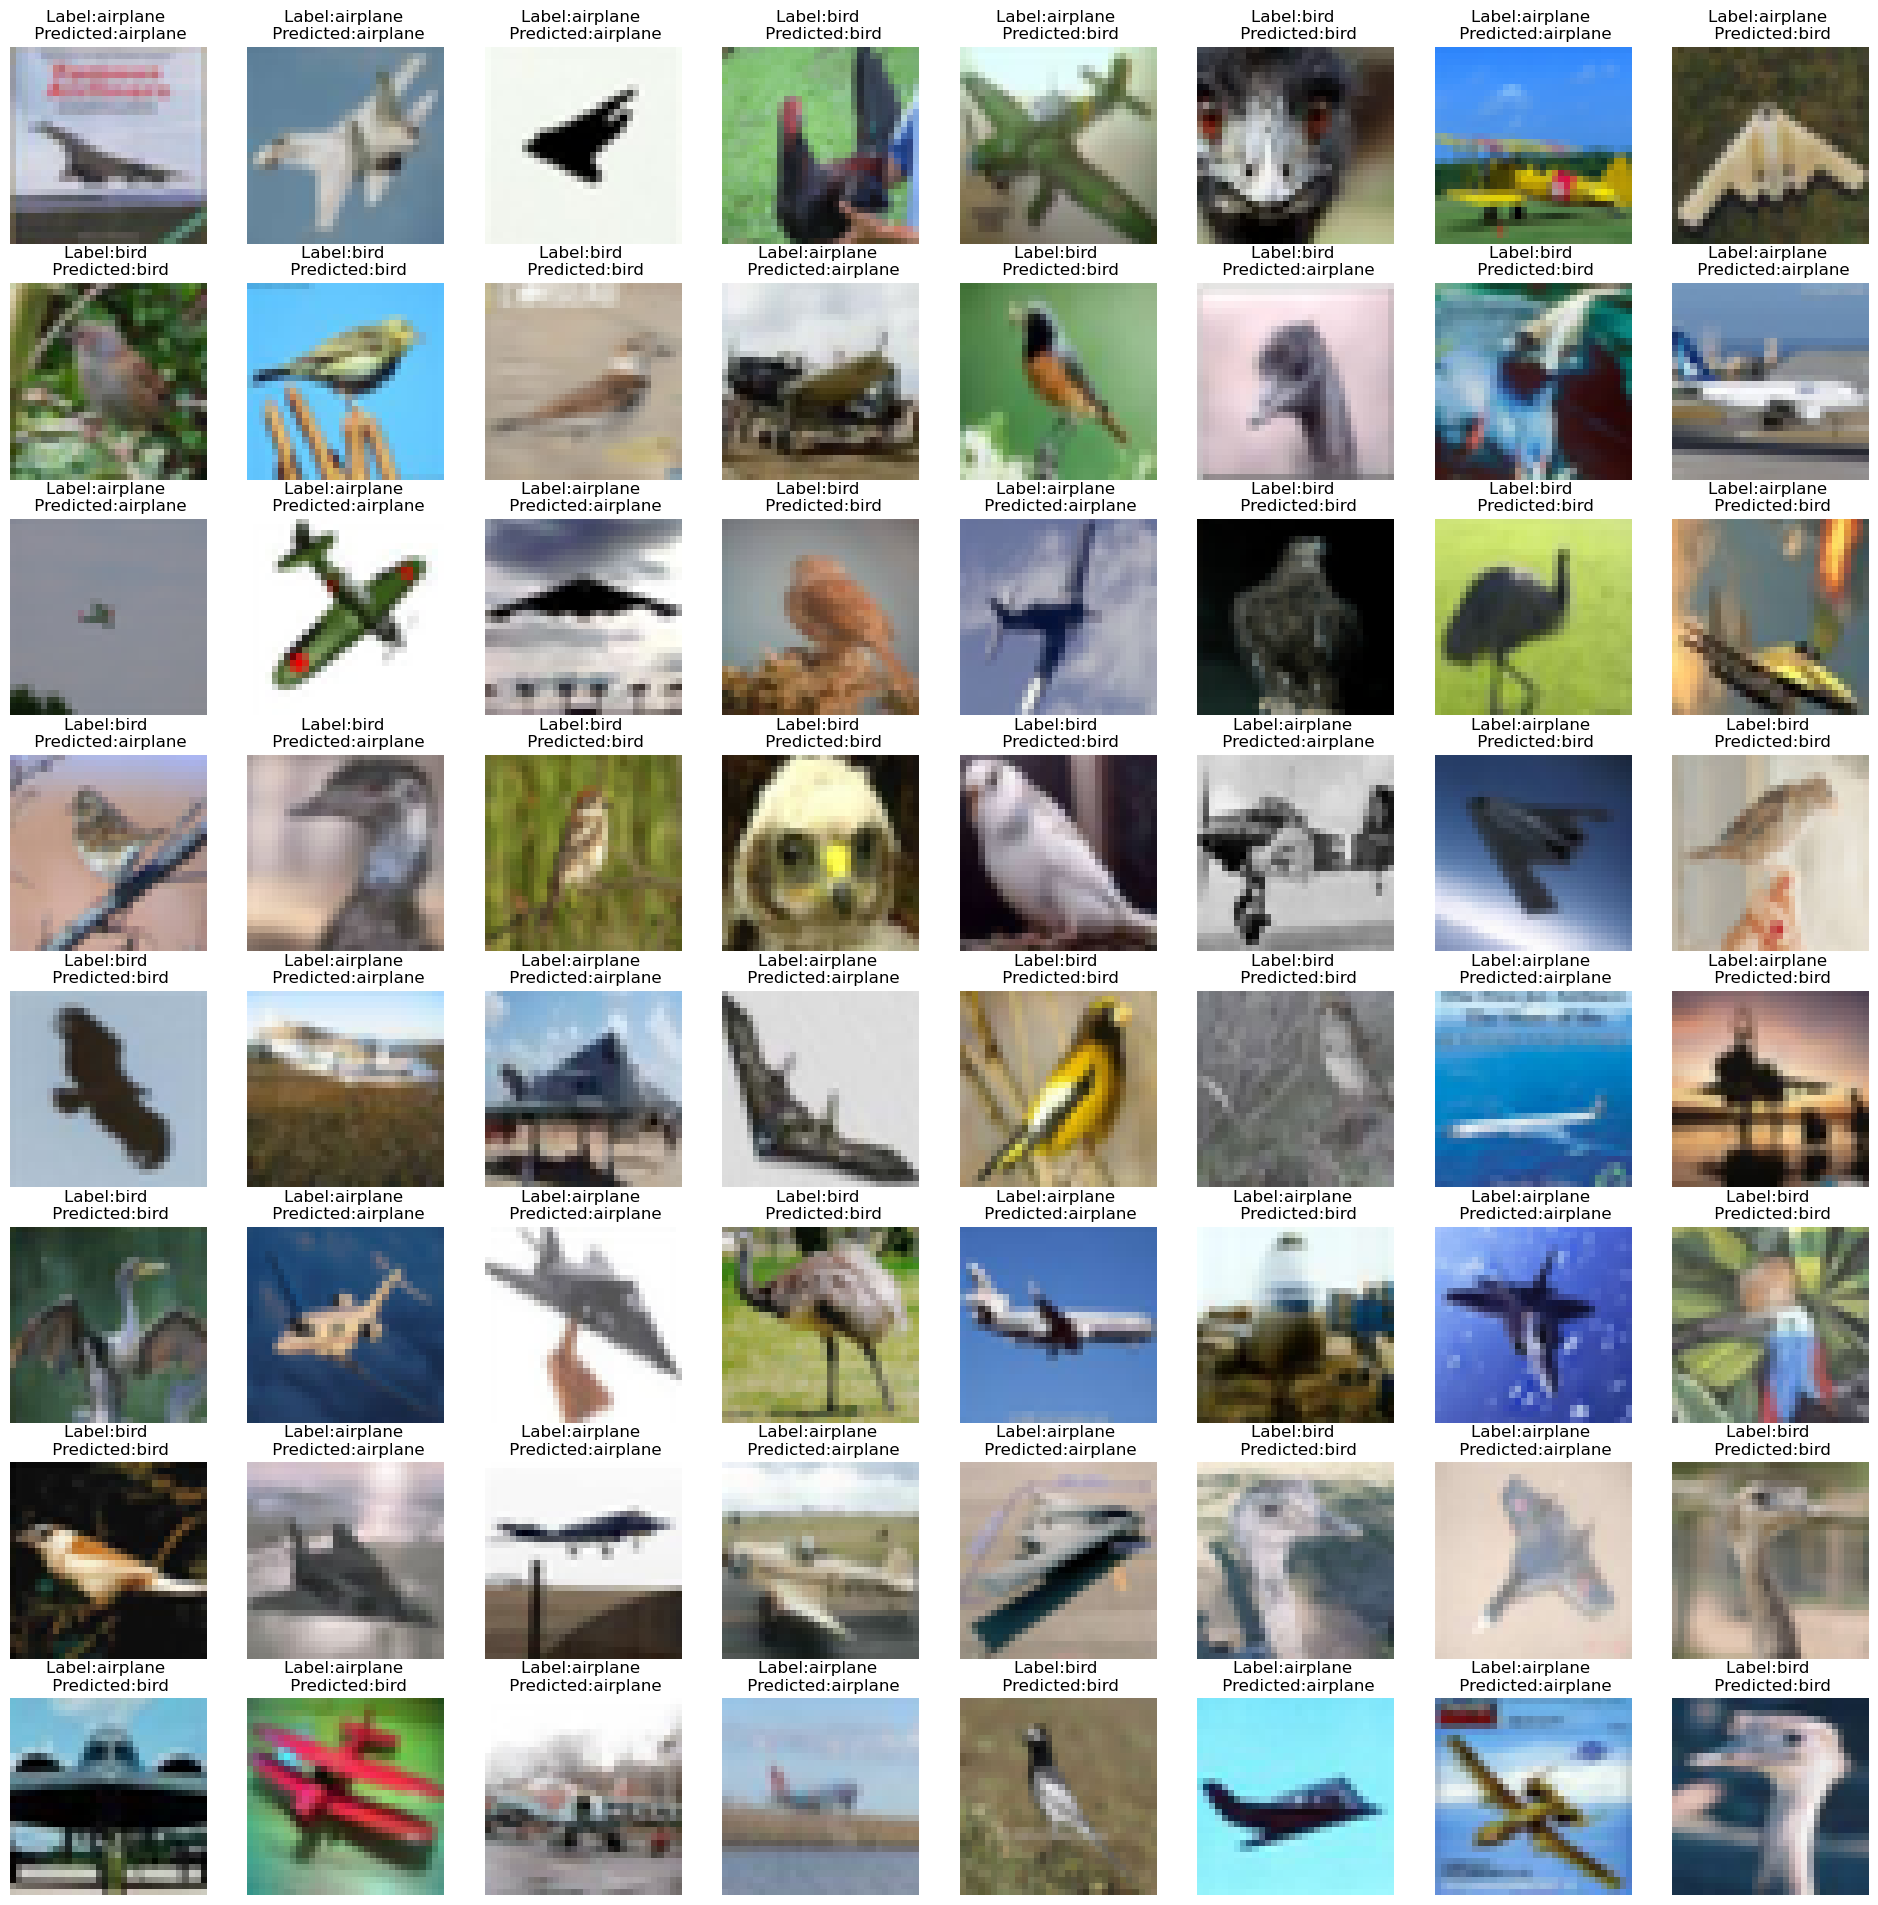

In [177]:
imgs, labels = next(iter(val_loader))

mean = torch.tensor([0.4915, 0.4823, 0.4468])
std = torch.tensor([0.2470, 0.2435, 0.2616])

mean = mean.view(1, -1, 1, 1).to(imgs.device)
std = std.view(1, -1, 1, 1).to(imgs.device)

imgs = imgs * std + mean


with torch.no_grad():
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    outs = model(imgs)
    _, predicted = torch.max(outs, dim=1)


    fig, axs = plt.subplots(8, 8, figsize=(24, 24))
    for i in range(8):
        for j in range(8):
            ax = axs[i, j]
            img = imgs[i*8+j].permute(1, 2, 0).cpu().numpy()
            
            ax.imshow(img)
            ax.set_title(f'Label:{class_name[labels[i*8+j]]} \n Predicted:{class_name[predicted[i*8+j]]}')
            ax.set_axis_off();

In [178]:
ConvKer13 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(1, 3), padding=(0, 1)),
    nn.Tanh(),
    nn.MaxPool2d(2, 2,),
    nn.Conv2d(32, 16, kernel_size=(1, 3), padding=(0, 1)),
    nn.Tanh(),
    nn.MaxPool2d(2, 2,),
    nn.Flatten(),
    nn.Linear(16*8*8, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

In [179]:
model = ConvKer13.to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    100,
    optimizer,
    model,
    loss_fn,
    train_loader
)

validate(model, train_loader, val_loader)

2024-02-24 18:03:24.429571 Epoch:1 Train Loss:0.57340
2024-02-24 18:03:32.151314 Epoch:10 Train Loss:0.34557
2024-02-24 18:03:40.498572 Epoch:20 Train Loss:0.29813
2024-02-24 18:03:48.776217 Epoch:30 Train Loss:0.27323
2024-02-24 18:03:57.244270 Epoch:40 Train Loss:0.25183
2024-02-24 18:04:06.172226 Epoch:50 Train Loss:0.23515
2024-02-24 18:04:15.101937 Epoch:60 Train Loss:0.21903
2024-02-24 18:04:23.956086 Epoch:70 Train Loss:0.20172
2024-02-24 18:04:32.269995 Epoch:80 Train Loss:0.18382
2024-02-24 18:04:40.491479 Epoch:90 Train Loss:0.16491
2024-02-24 18:04:48.745922 Epoch:100 Train Loss:0.14625
train accuracy: 0.95
val accuracy: 0.89


{'train': 0.9499, 'val': 0.8945}

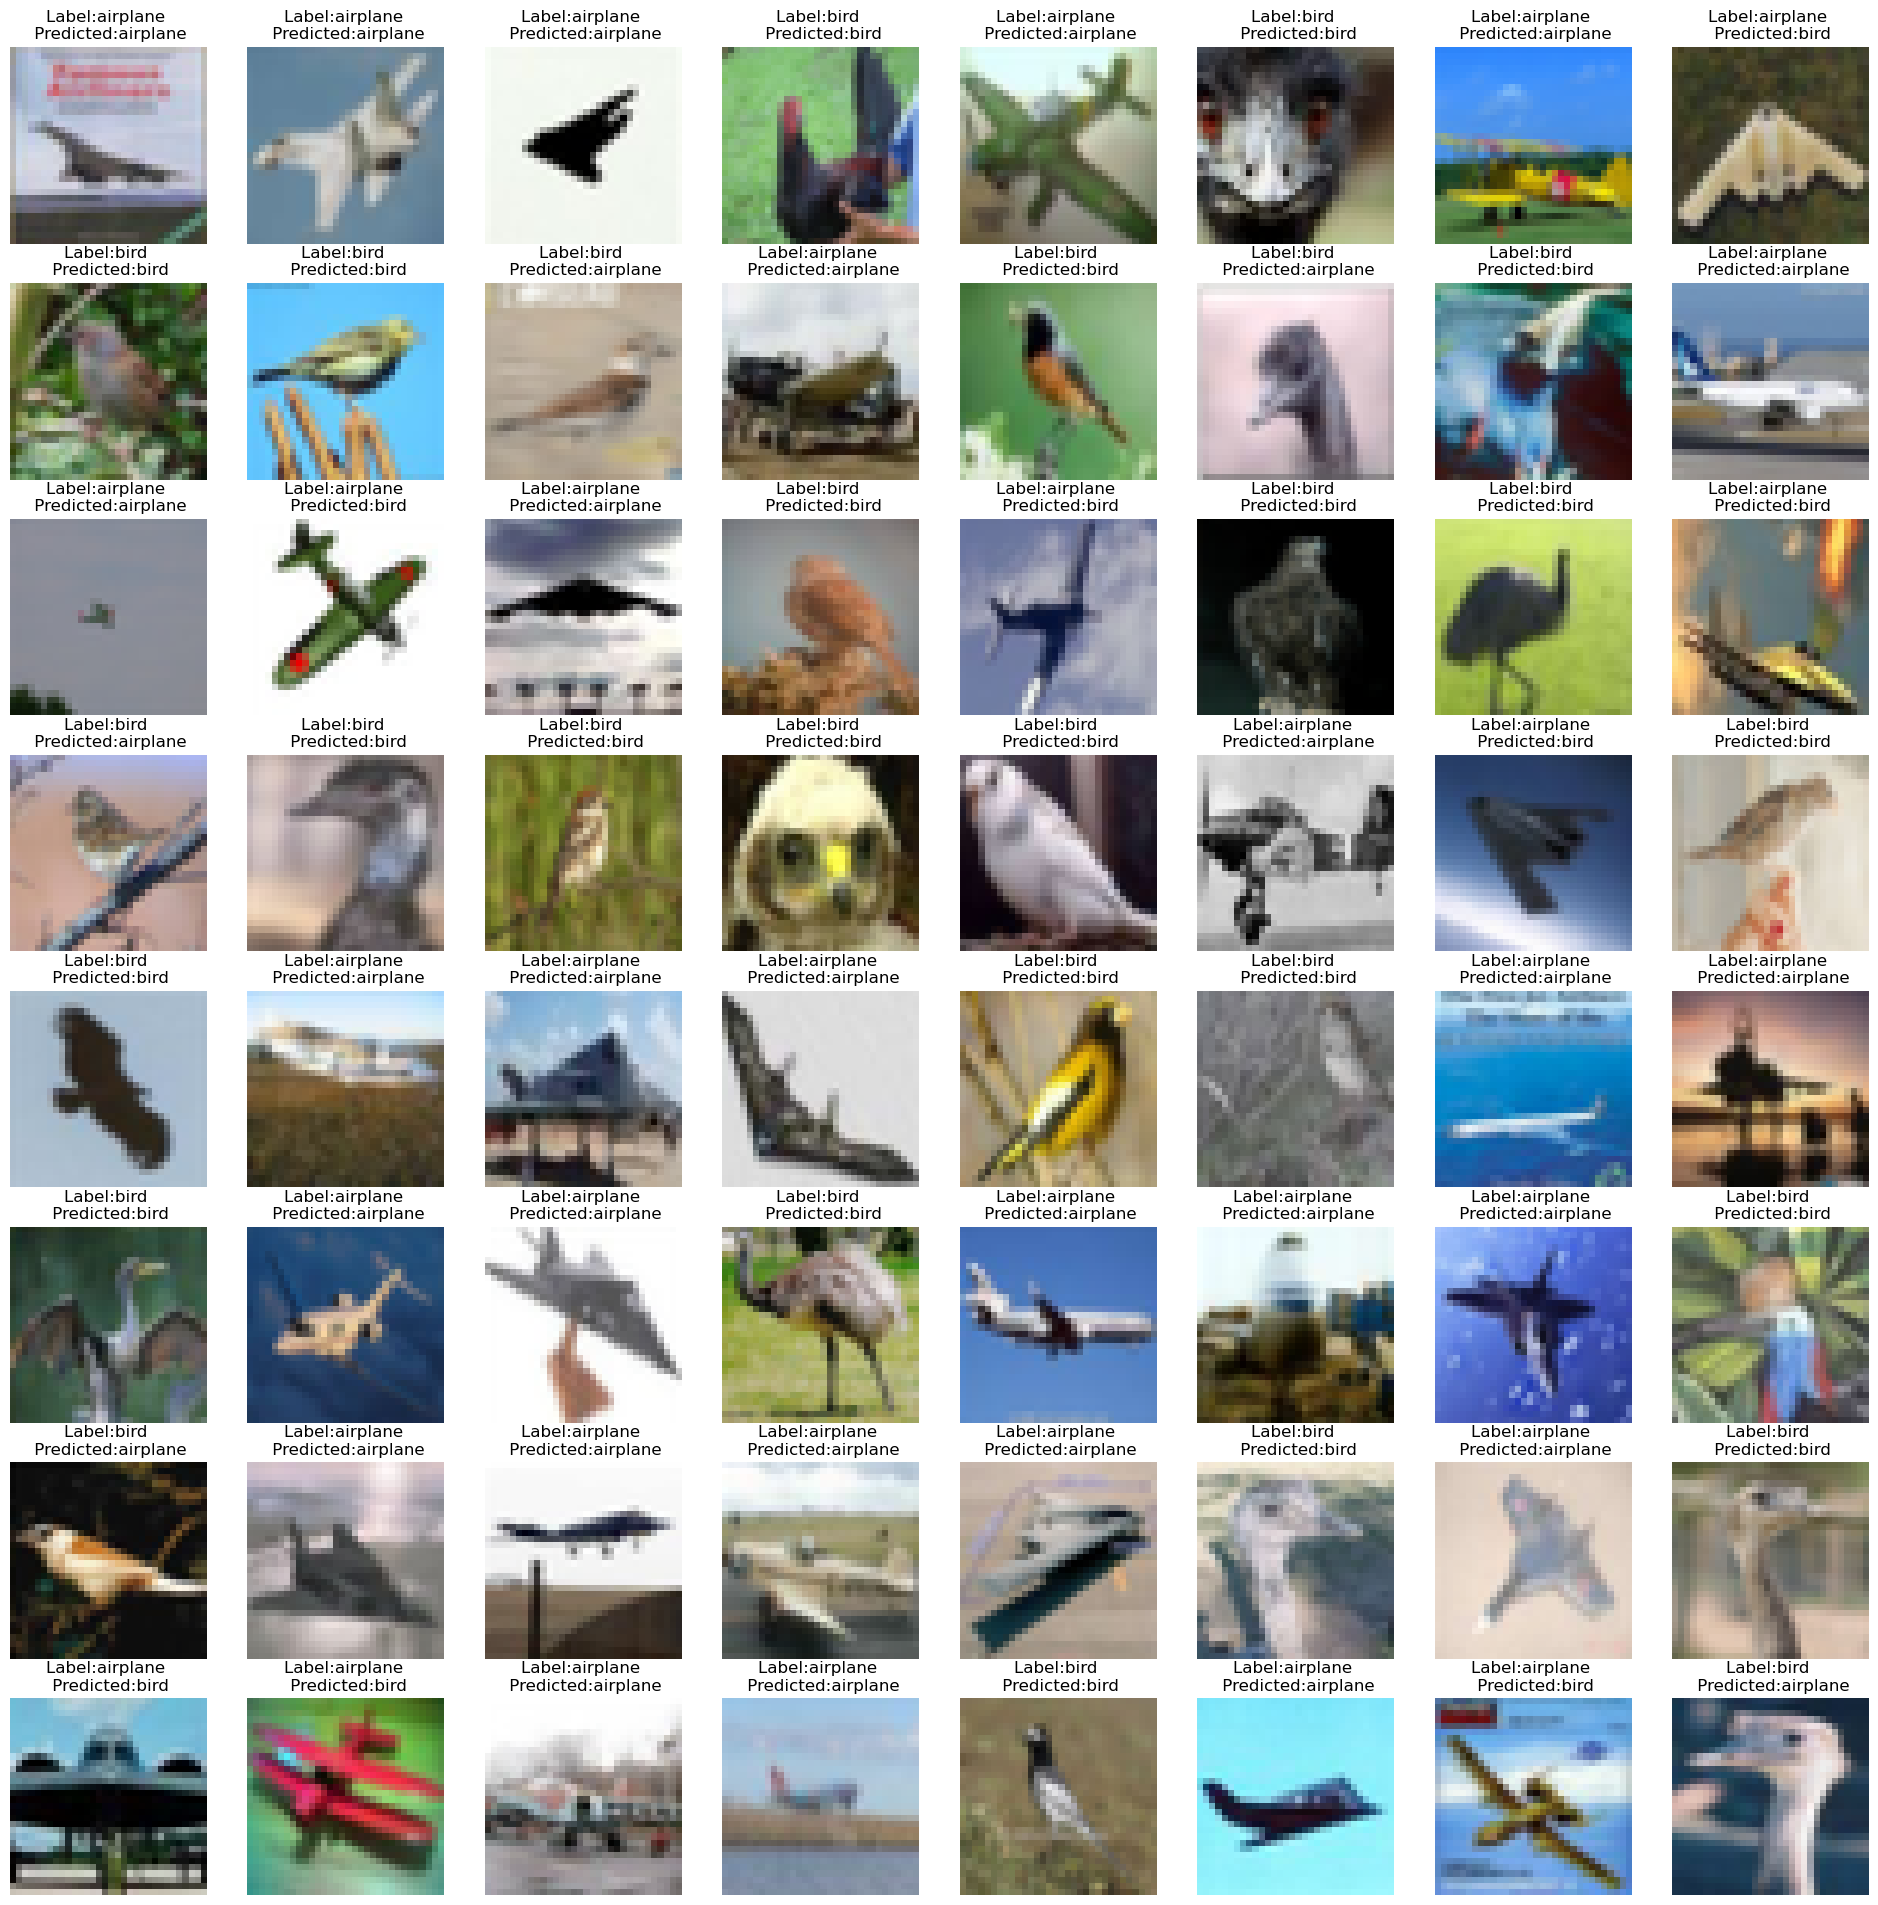

In [180]:
imgs, labels = next(iter(val_loader))

mean = torch.tensor([0.4915, 0.4823, 0.4468])
std = torch.tensor([0.2470, 0.2435, 0.2616])

mean = mean.view(1, -1, 1, 1).to(imgs.device)
std = std.view(1, -1, 1, 1).to(imgs.device)

imgs = imgs * std + mean


with torch.no_grad():
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    outs = model(imgs)
    _, predicted = torch.max(outs, dim=1)


    fig, axs = plt.subplots(8, 8, figsize=(24, 24))
    for i in range(8):
        for j in range(8):
            ax = axs[i, j]
            img = imgs[i*8+j].permute(1, 2, 0).cpu().numpy()
            
            ax.imshow(img)
            ax.set_title(f'Label:{class_name[labels[i*8+j]]} \n Predicted:{class_name[predicted[i*8+j]]}')
            ax.set_axis_off();

In [185]:
cifar_xclass = [img for img, _ in cifar if _ not in [0, 2]]
xclass_loader = torch.utils.data.DataLoader(cifar_xclass, batch_size=10, shuffle=False)

In [194]:
torch.softmax(torch.tensor([-5., 5.]), dim=0)
4.5398e-05+9.9995e-01

0.999995398

In [241]:
imgs = next(iter(xclass_loader))
imgs = imgs * std + mean

with torch.no_grad():
    imgs = imgs.to(device=device)
    logits = model(imgs)
    _, preds = torch.max(logits, dim=1)
    
    probs = torch.softmax(logits, dim=1)
    imgs = [img for i, img in enumerate(imgs) if (probs[i, :]>0.95).sum()]
    labels = [int(pred.cpu()) for i, pred in enumerate(preds) if (probs[i, :]>0.95).sum()]
    print(len(imgs))

2


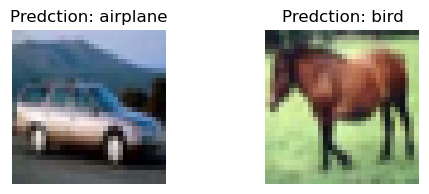

In [242]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2))

for i, img in enumerate(imgs):
    axs[i].imshow(img.permute(1, 2, 0).cpu())
    axs[i].set_title(f'Predction: {class_name[labels[i]]}')
    axs[i].set_axis_off();